# 1. Bulid Convolution AutoEncoder(CAE) 
# 2. Thresholding rule learning classfication

In [0]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten, MaxPool2D, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model, Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Handcrafted Functions
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode]), plt.plot(history.history['val_'+mode])
    plt.title(title), plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [0]:
data = np.load('/content/drive/My Drive/test_colab/dataset_2_char_cat_45000_15000_140.npy')

In [4]:
data.shape

(60000, 14001)

In [4]:
# Train, Test Split
# Train : for CAE Learning + Detection Thresholding
# Test : only for validation
X, Y = data[:, 1:], data[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(42000, 14000) (42000,)
(18000, 14000) (18000,)


In [0]:
Y_train_cat, Y_test_cat = to_categorical(Y_train), to_categorical(Y_test)

## 1. Bulid Convolution AutoEncoder

In [0]:
cae_input = Input((X_train.shape[1], ))  # adapt this if using `channels_first` image data format
H = Reshape((100, 140, 1))(cae_input)

# Encoded
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(H)
H = MaxPooling2D((2,2))(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(H)
H = MaxPooling2D((2,2))(H)

# Decoded

H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(H)
H = UpSampling2D((2, 2))(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(H)
H = UpSampling2D((2, 2))(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu')(H)
H = Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation='relu')(H)

cae_output = Flatten()(H)
cae_model = Model(cae_input,cae_output)
cae_model.summary()


In [0]:
%%time
adam = Adam(lr = 1e-04)
cae_model.compile(loss='categorical_crossentropy', 
                  optimizer= adam, metrics=['accuracy'])

In [0]:
# cae_model.save('/content/drive/My Drive/test_colab/cnn.h5')

In [6]:
cae_model = load_model('/content/drive/My Drive/test_colab/cae.h5')
cae_model.summary()














Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 14000)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 100, 140, 1)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 140, 32)      160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 70, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 70, 32)        4128      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 35, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 35, 32

In [7]:
# Lock Weight
for i, l in enumerate(cae_model.layers):
    l.trainable = False
    l.name = 'cae_'+str(i)
cae_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cae_0 (InputLayer)           (None, 14000)             0         
_________________________________________________________________
cae_1 (Reshape)              (None, 100, 140, 1)       0         
_________________________________________________________________
cae_2 (Conv2D)               (None, 100, 140, 32)      160       
_________________________________________________________________
cae_3 (MaxPooling2D)         (None, 50, 70, 32)        0         
_________________________________________________________________
cae_4 (Conv2D)               (None, 50, 70, 32)        4128      
_________________________________________________________________
cae_5 (MaxPooling2D)         (None, 25, 35, 32)        0         
_________________________________________________________________
cae_6 (Conv2D)               (None, 25, 35, 32)        4128

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cae_0 (InputLayer)           (None, 14000)             0         
_________________________________________________________________
cae_1 (Reshape)              (None, 100, 140, 1)       0         
_________________________________________________________________
cae_2 (Conv2D)               (None, 100, 140, 32)      160       
_________________________________________________________________
cae_3 (MaxPooling2D)         (None, 50, 70, 32)        0         
_________________________________________________________________
cae_4 (Conv2D)               (None, 50, 70, 32)        4128      
_________________________________________________________________
cae_5 (MaxPooling2D)         (None, 25, 35, 32)        0         
_________________________________________________________________
cae_6 (Conv2D)               (None, 25, 35, 32)        4128

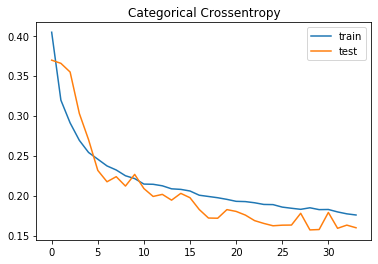

In [13]:
# Build Classifier Model
classifier_input = cae_model.get_layer('cae_12').output
H = Reshape((100, 140, 1))(classifier_input)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPool2D((2, 2))(H)
H = Dropout(0.5)(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPool2D((2, 2))(H)
H = Dropout(0.5)(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPool2D((2, 2))(H)
H = Dropout(0.5)(H)
H = Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='tanh')(H)
H = MaxPool2D((2, 2))(H)
H = Dropout(0.5)(H)
H = Flatten()(H)
H = Dense(1024, activation='tanh')(H)
H = Dense(256, activation='tanh')(H)
classifier_output = Dense(2, activation='softmax')(H)
classifier_model = Model(cae_model.input, classifier_output)
classifier_model.summary()
classifier_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='auto', patience=5)
history_classifier_model = classifier_model.fit(X_train, Y_train_cat, validation_data=(X_test, Y_test_cat), epochs=1000, batch_size=500, verbose=2, callbacks=[es])
plot_history(classifier_model, mode='loss', title='Categorical Crossentropy')
Y_train_hat = classifier_model.predict(X_train)
Y_test_hat = classifier_model.predict(X_test)
classifier_model.save('/content/drive/My Drive/test_colab/classifier.h5')